## Import libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

### Load dataset 

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## Quick analysis

In [3]:
print(f'Train: {train.shape}')
print(f'Test {test.shape}')

Train: (20000, 22)
Test (5000, 21)


### Train

In [4]:
train.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [5]:
train.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,7335.000000
mean,33.940704,-117.893072,1352.380350,10.834250,1129.599200,1.418150,30.135000,297.176950,366.405044
std,2.126810,7.377726,646.100291,6.033166,603.330519,0.493267,21.863645,212.007298,120.485687
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.323000,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165025,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

### Test

In [7]:
test.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description
0,1500 LEIGHTON AV,NaN,34.0128,-118.3045,03/03/2020 12:00:00 AM,03/03/2020 12:00:00 AM,2000.0,3.0,Southwest,376.0,...,0416 1241 1243 1813 1821 2000,28.0,F,H,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont
1,100 S NORMANDIE AV,NaN,34.0726,-118.3029,06/01/2020 12:00:00 AM,04/25/2020 12:00:00 AM,1700.0,20.0,Olympic,2014.0,...,0344 0394,26.0,M,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont
2,300 E 111TH ST,NaN,33.9348,-118.2695,08/28/2020 12:00:00 AM,08/27/2020 12:00:00 AM,900.0,18.0,Southeast,1844.0,...,1822 0701 1914 0355 1202 0100,62.0,F,B,721.0,HIGH SCHOOL,NaN,NaN,IC,Invest Cont
3,1300 S LA BREA AV,NaN,34.0497,-118.3442,12/23/2020 12:00:00 AM,12/03/2020 12:00:00 AM,2200.0,7.0,Wilshire,765.0,...,NaN,0.0,NaN,NaN,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont
4,11000 MORRISON ST,NaN,34.1611,-118.3704,08/30/2020 12:00:00 AM,08/29/2020 12:00:00 AM,130.0,15.0,N Hollywood,1555.0,...,1501,37.0,F,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,AO,Adult Other


In [8]:
test.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,1847.000000
mean,33.957169,-117.952663,1337.737400,10.736600,1119.879800,1.414000,30.592000,300.858800,364.014077
std,1.986742,6.890957,663.922202,6.051524,605.143645,0.492598,21.897905,212.253742,119.489932
min,0.000000,-118.650300,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.010800,-118.431200,900.000000,6.000000,628.000000,1.000000,14.000000,101.000000,309.000000
50%,34.058000,-118.323200,1430.000000,11.000000,1138.000000,1.000000,31.000000,203.000000,400.000000
75%,34.162250,-118.274600,1900.000000,16.000000,1622.250000,2.000000,46.000000,501.000000,400.000000
max,34.327500,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,957.000000,516.000000


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               5000 non-null   object 
 1   Cross_Street           810 non-null    object 
 2   Latitude               5000 non-null   float64
 3   Longitude              5000 non-null   float64
 4   Date_Reported          5000 non-null   object 
 5   Date_Occurred          5000 non-null   object 
 6   Time_Occurred          5000 non-null   float64
 7   Area_ID                5000 non-null   float64
 8   Area_Name              5000 non-null   object 
 9   Reporting_District_no  5000 non-null   float64
 10  Part 1-2               5000 non-null   float64
 11  Modus_Operandi         4316 non-null   object 
 12  Victim_Age             5000 non-null   float64
 13  Victim_Sex             4357 non-null   object 
 14  Victim_Descent         4357 non-null   object 
 15  Prem

### Plots

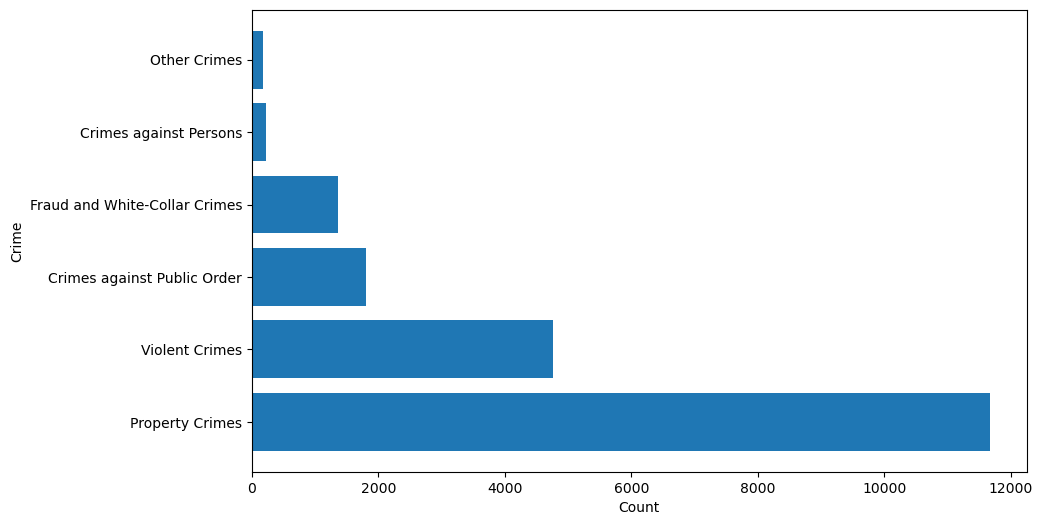

In [5]:
freq = train['Crime_Category'].value_counts()
plt.figure(figsize=(10, 6))
plt.barh(freq.index, freq.values)
plt.xlabel('Count')
plt.ylabel('Crime')
plt.show()

<Axes: >

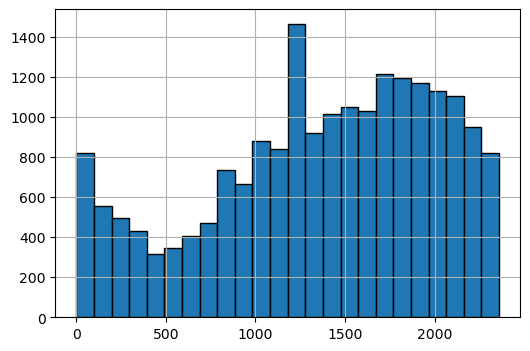

In [11]:
train["Time_Occurred"].hist(figsize=(6, 4), bins=24, edgecolor='black')

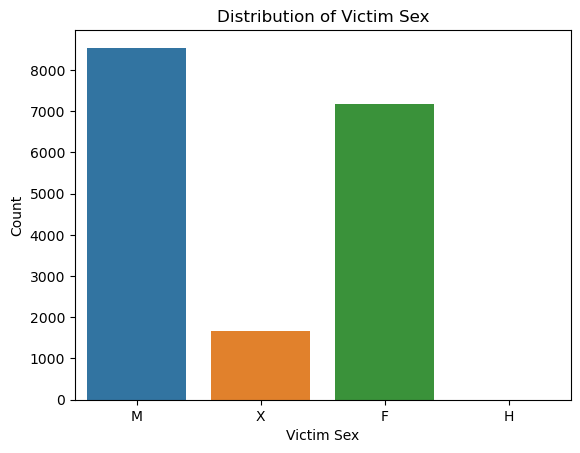

In [12]:
sns.countplot(x='Victim_Sex', data=train)
plt.xlabel('Victim Sex')
plt.ylabel('Count')
plt.title('Distribution of Victim Sex')
plt.show()

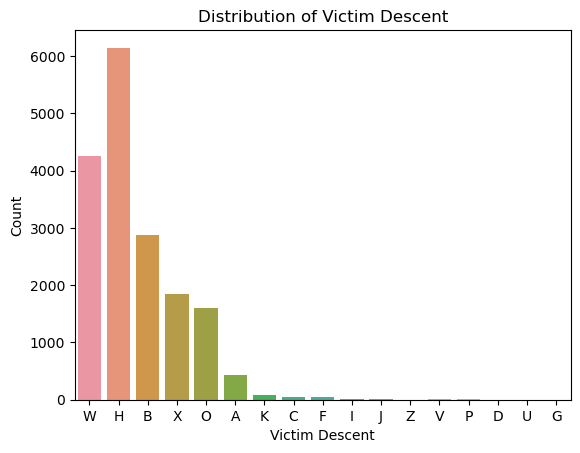

In [13]:
sns.countplot(x='Victim_Descent', data=train)
plt.xlabel('Victim Descent')
plt.ylabel('Count')
plt.title('Distribution of Victim Descent')
plt.show()

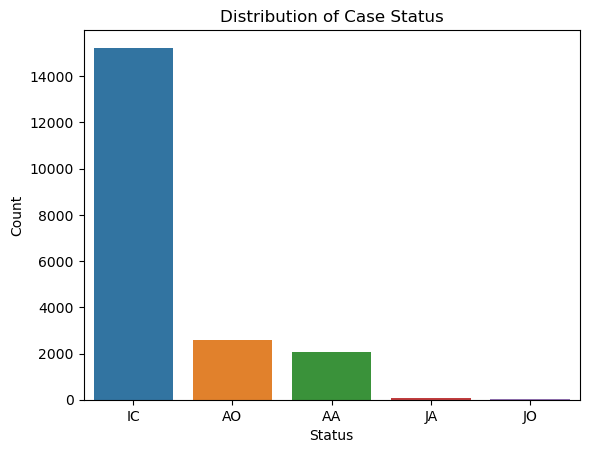

In [14]:
sns.countplot(x='Status', data=train)
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Distribution of Case Status')
plt.show()

### Correlation matrix

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
columns_to_encode = ['Crime_Category', 'Victim_Sex', 'Victim_Descent', 'Status']

encoded_data = {col: le.fit_transform(train[col]) for col in columns_to_encode}
e_train = train.drop(columns=columns_to_encode).assign(**encoded_data)

In [16]:
e_train.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status_Description,Crime_Category,Victim_Sex,Victim_Descent,Status
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,101.0,STREET,NaN,NaN,Invest Cont,4,2,14,2
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,4,2,6,2
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,501.0,SINGLE FAMILY DWELLING,NaN,NaN,Invest Cont,4,2,1,2
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,101.0,STREET,NaN,NaN,Invest Cont,4,2,6,2
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,4,3,15,2


In [7]:
cols_to_plot = [
    'Latitude',
    'Longitude',
    'Time_Occurred',
    'Area_ID',
    'Reporting_District_no',
    'Victim_Age',
    'Victim_Sex',
    'Victim_Descent',
    'Premise_Code',
    'Weapon_Used_Code',
    'Part 1-2',
    'Status',
    'Crime_Category'
]

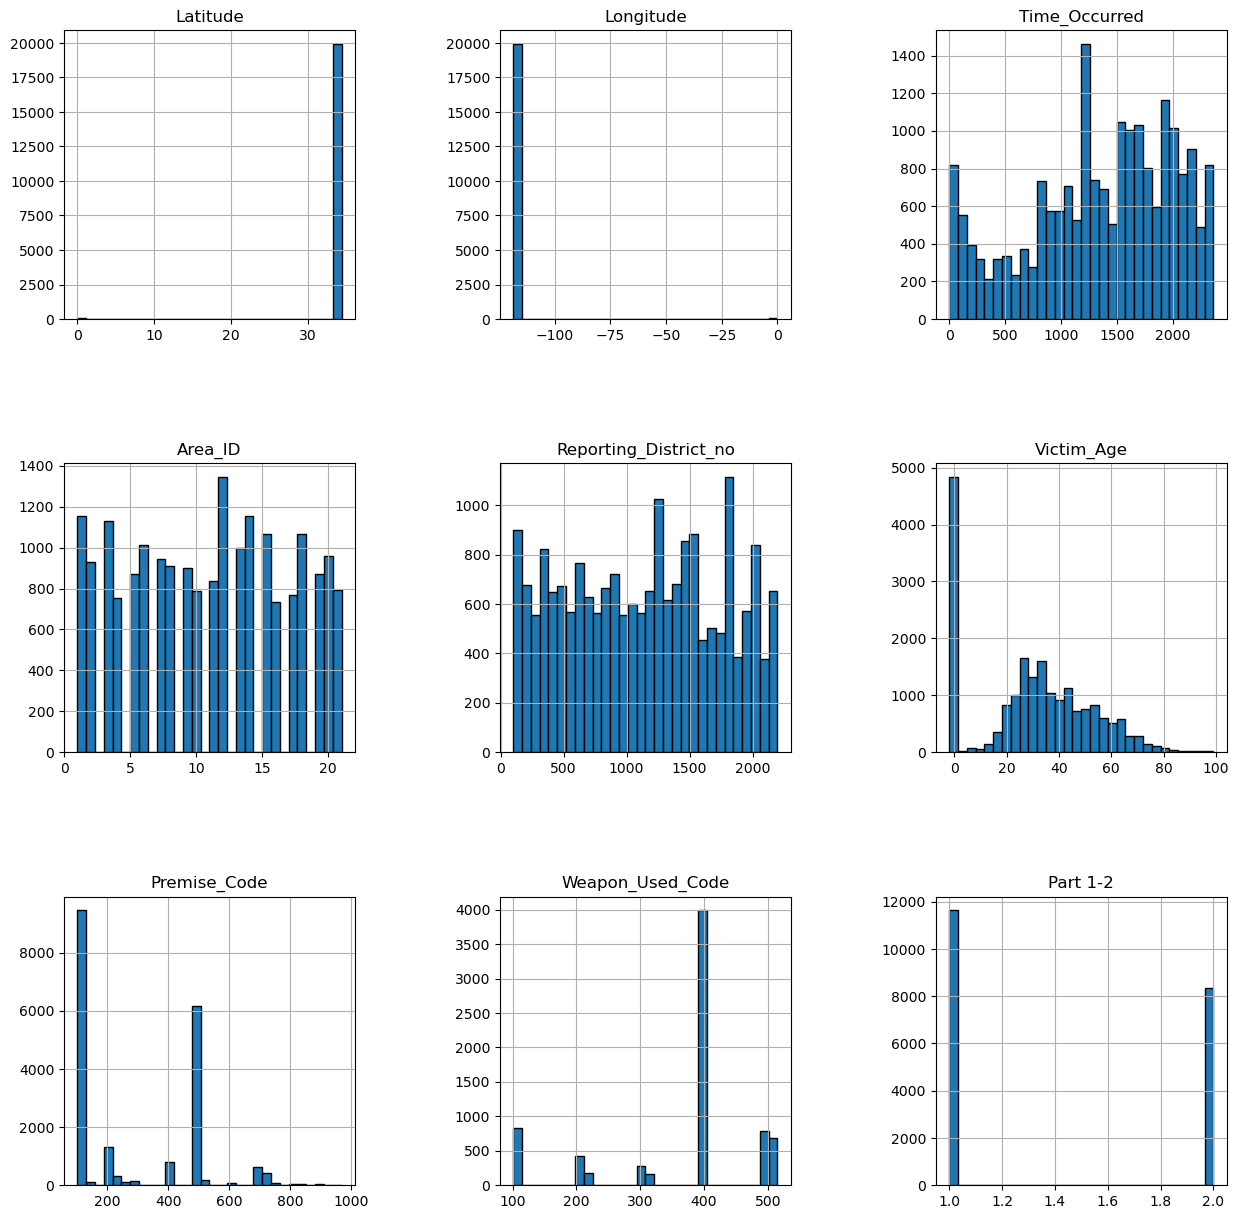

In [8]:
train[cols_to_plot].hist(figsize=(15, 15), bins=30, edgecolor='black')
plt.subplots_adjust(hspace=0.5, wspace=0.5)

<Axes: >

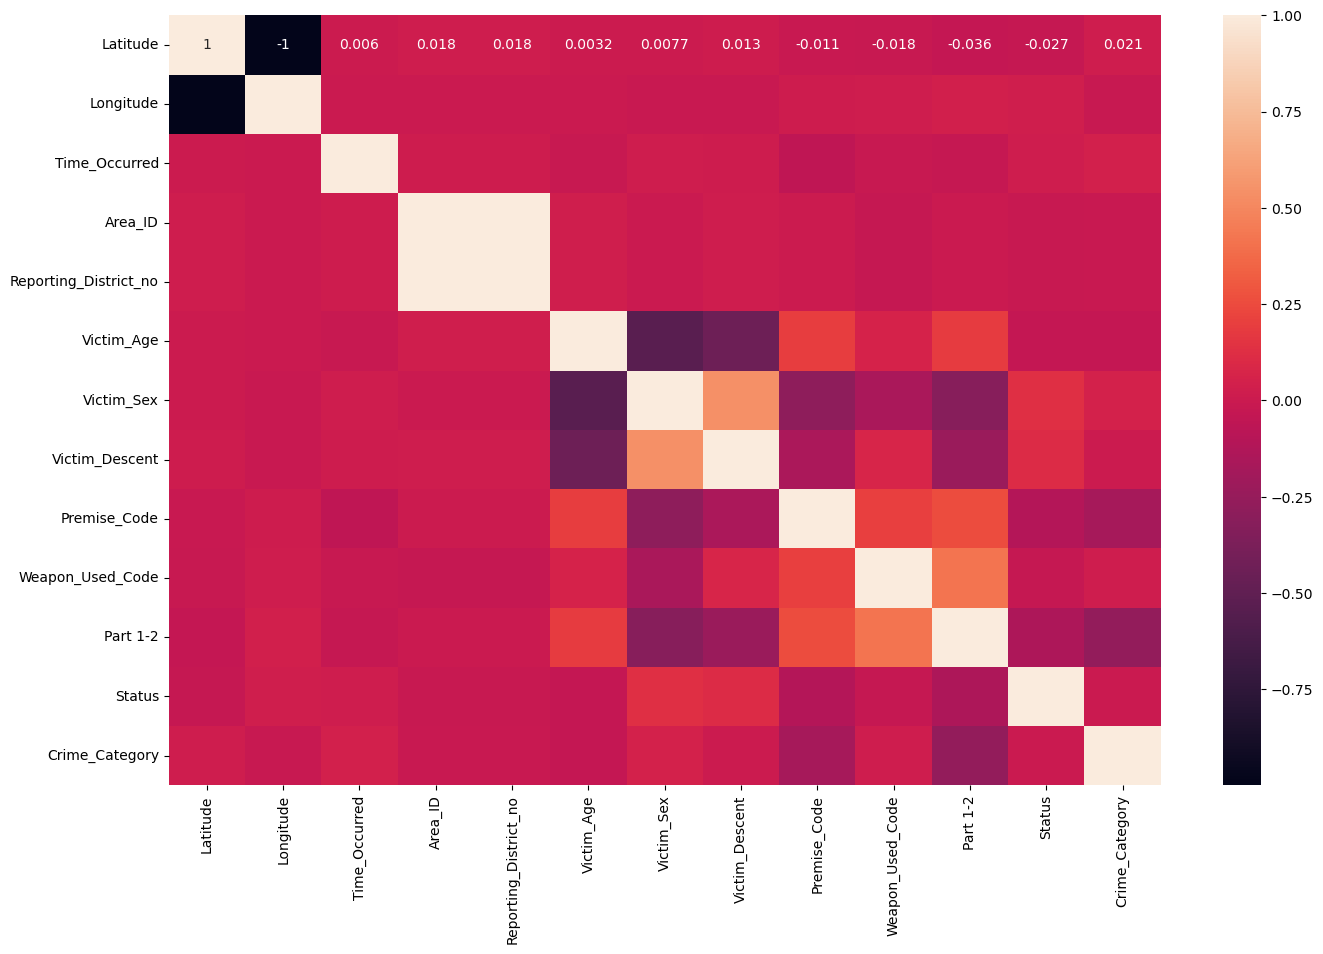

In [19]:
plt.figure(figsize=(16, 10))
sns.heatmap(e_train[cols_to_plot].corr(), annot=True)

### Box plot

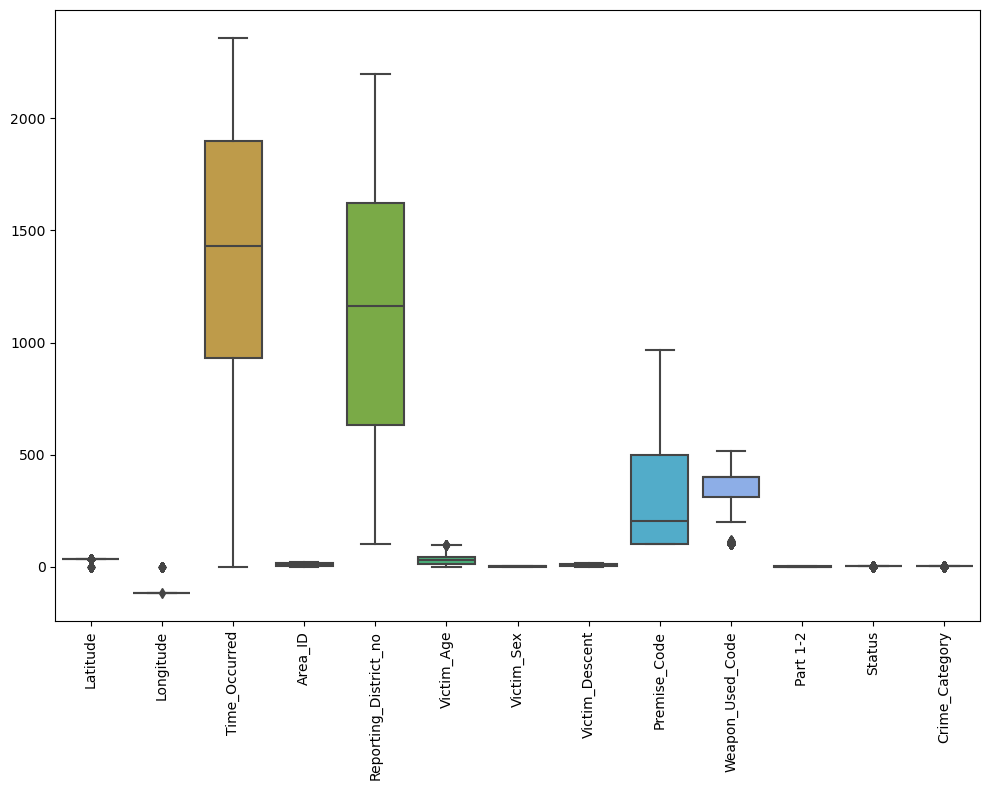

In [20]:
plt.figure(figsize=(10,8))
sns.boxplot(data=e_train[cols_to_plot])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Handle missing data

In [21]:
train.isnull().sum()

Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

In [22]:
test.isnull().sum()

Location                    0
Cross_Street             4190
Latitude                    0
Longitude                   0
Date_Reported               0
Date_Occurred               0
Time_Occurred               0
Area_ID                     0
Area_Name                   0
Reporting_District_no       0
Part 1-2                    0
Modus_Operandi            684
Victim_Age                  0
Victim_Sex                643
Victim_Descent            643
Premise_Code                0
Premise_Description         1
Weapon_Used_Code         3153
Weapon_Description       3153
Status                      0
Status_Description          0
dtype: int64

In [9]:
train = train.replace({None: np.nan, "": np.nan})
train = train.fillna(value=0)

test = test.replace({None: np.nan, "": np.nan})
test = test.fillna(value=0)

## Preprocess

In [10]:
train['Victim_Sex'] = train['Victim_Sex'].apply(lambda x: "Unknown" if x == 0 else x)
train['Victim_Descent'] = train['Victim_Descent'].apply(lambda x: "Unknown" if x == 0 else x)

test['Victim_Sex'] = test['Victim_Sex'].apply(lambda x: "Unknown" if x == 0 else x)
test['Victim_Descent'] = test['Victim_Descent'].apply(lambda x: "Unknown" if x == 0 else x)

In [11]:
train.drop(columns=['Location', 'Area_Name', 'Premise_Description', 'Weapon_Description', 'Status_Description'], axis=1, inplace=True)
test.drop(columns=['Location', 'Area_Name', 'Premise_Description', 'Weapon_Description', 'Status_Description'], axis=1, inplace=True)

In [12]:
from sklearn.pipeline import Pipeline, FunctionTransformer

def convert_date(x):
  x['Date_Reported'] = pd.to_datetime(x['Date_Reported'])
  x['Date_Occurred'] = pd.to_datetime(x['Date_Occurred'])
  return x

def create_report_delay(x):
  x['Report_delay'] = (x['Date_Reported'] - x['Date_Occurred']).dt.days
  return x

pipeline = Pipeline([
    ('convert_date', FunctionTransformer(convert_date, validate=False)),
    ('create_report_delay', FunctionTransformer(create_report_delay, validate=False))
])

train = pipeline.fit_transform(train)
test = pipeline.fit_transform(test)

C:\Users\quock\AppData\Local\Temp\ipykernel_34644\949812419.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x['Date_Reported'] = pd.to_datetime(x['Date_Reported'])
C:\Users\quock\AppData\Local\Temp\ipykernel_34644\949812419.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x['Date_Occurred'] = pd.to_datetime(x['Date_Occurred'])
C:\Users\quock\AppData\Local\Temp\ipykernel_34644\949812419.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x['Date_Reported'] = pd.to_datetime(x['Date_Reported'])
C:\Users\quock\AppData\Local\Temp\ipykernel_34644\949812419.py:5: UserWarnin

In [13]:
date_features = {
    'Day': 'day',
    'Month': 'month',
    'Year': 'year',
    'DOY': 'day_of_year',
    'Week': 'weekday'
}

def extract_date_features(df, date_columns):
    for date_col in date_columns:
        for feature, attr in date_features.items():
            df[f"{feature}_{date_col.split('_')[1]}"] = getattr(df[date_col].dt, attr)

extract_date_features(train, ['Date_Occurred', 'Date_Reported'])
extract_date_features(test, ['Date_Occurred', 'Date_Reported'])


In [14]:
train.drop(columns=['Date_Reported','Date_Occurred'],inplace=True)
test.drop(columns=['Date_Reported','Date_Occurred'],inplace=True)

In [15]:
def hour(time):
  time_str = f"{time:04d}"
  hours = time_str[:2]
  return hours

def minute(time):
  time_str = f"{time:04d}"
  minute = time_str[2:]
  return minute

In [16]:
def process_time_column(df, time_col):
    df[time_col] = df[time_col].astype(int)
    df['Hour_Occurred'] = df[time_col].apply(hour).astype(int)
    df['Minute_Occurred'] = df[time_col].apply(minute).astype(int)

process_time_column(train, 'Time_Occurred')
process_time_column(test, 'Time_Occurred')

In [17]:
train.drop(columns=['Time_Occurred'], inplace=True)
test.drop(columns=['Time_Occurred'], inplace=True)

In [18]:
train['Victim_Age'] = train['Victim_Age'].apply(lambda x: 0 if x < 0 else x)
test['Victim_Age'] = test['Victim_Age'].apply(lambda x: 0 if x < 0 else x)  

In [19]:
def convert_cs_col(df):
    df['Cross_Street'] = df['Cross_Street'].apply(lambda x: 1 if x != 0 else x)
    df['Cross_Street'] = df['Cross_Street'].astype(int)

convert_cs_col(train)
convert_cs_col(test)

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

num_cols = ['Cross_Street', 'Latitude', 'Longitude', 'Area_ID', 'Reporting_District_no','Victim_Age', 'Premise_Code',
            'Weapon_Used_Code','Report_delay','Day_Occurred','Month_Occurred', 'Year_Occurred',
            'DOY_Occurred', 'Week_Occurred','Day_Reported', 'Month_Reported', 'Year_Reported',
            'DOY_Reported','Week_Reported', 'Hour_Occurred', 'Minute_Occurred']

cat_cols = ['Part 1-2', 'Victim_Sex', 'Victim_Descent', 'Status']

col_trans = ColumnTransformer([
    ('scalar', MinMaxScaler(), num_cols),
    ('ohe', OneHotEncoder(), cat_cols)
])

In [ ]:
train_transformed = col_trans.fit_transform(train)
col_names_train = col_trans.get_feature_names_out()

ccn_train = []
for col_name in col_names_train:
  if "__" in col_name:
    cn = col_name.split("__")[1]
    ccn_train.append(cn)
  else:
    ccn_train.append(col_name)  

train_transformed = pd.DataFrame(train_transformed, columns=ccn_train)
train = pd.concat([train.drop(columns=num_cols+cat_cols), train_transformed], axis=1)

In [ ]:
test_transformed = col_trans.fit_transform(test)
col_names_test = col_trans.get_feature_names_out()

ccn_test = []
for col_name in col_names_test:
  if "__" in col_name:
    cn = col_name.split("__")[1]
    ccn_test.append(cn)
  else:
    ccn_test.append(col_name)

test_transformed = pd.DataFrame(test_transformed, columns=ccn_test)
test = pd.concat([test.drop(columns=num_cols+cat_cols), test_transformed], axis=1)

In [23]:
train['Modus_Operandi'] = train['Modus_Operandi'].astype(str)
train['Modus_Operandi'] = train['Modus_Operandi'].apply(lambda x: x.split())

test['Modus_Operandi'] = test['Modus_Operandi'].astype(str)
test['Modus_Operandi'] = test['Modus_Operandi'].apply(lambda x: x.split())

In [24]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

modus_encoded = mlb.fit_transform(train['Modus_Operandi'])
modus_encoded_train = pd.DataFrame(modus_encoded, columns=mlb.classes_)

modus_encoded_train.index = train.index
train = pd.concat([train, modus_encoded_train], axis=1)

me = mlb.fit_transform(test['Modus_Operandi'])
modus_encoded_test = pd.DataFrame(me, columns=mlb.classes_)

modus_encoded_test.index = test.index
test = pd.concat([test, modus_encoded_test], axis=1)

In [25]:
train.drop(columns=['Modus_Operandi'], inplace=True)
test.drop(columns=['Modus_Operandi'], inplace=True)

In [26]:
missing_cols_in_test = set(train.columns) - set(test.columns)
missing_cols_in_train = set(test.columns) - set(train.columns)

for col in missing_cols_in_test:
  test[col] = 0
    
for col in missing_cols_in_train:
  train[col] = 0

C:\Users\quock\AppData\Local\Temp\ipykernel_34644\1964682593.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[col] = 0
C:\Users\quock\AppData\Local\Temp\ipykernel_34644\1964682593.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[col] = 0
C:\Users\quock\AppData\Local\Temp\ipykernel_34644\1964682593.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

In [27]:
col_order = train.columns
f_test = test[col_order]

In [28]:
f_test.drop(columns=['Crime_Category'],inplace=True)

C:\Users\quock\AppData\Local\Temp\ipykernel_34644\235238067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_test.drop(columns=['Crime_Category'],inplace=True)


In [29]:
print(f"Train Data Shape : {train.shape}")
print(f"Test Data Shape : {f_test.shape}")

Train Data Shape : (20000, 553)
Test Data Shape : (5000, 552)


## Model building

In [32]:
x_train = train.drop(columns=['Crime_Category'])
y_train = train['Crime_Category']

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

c:\Users\quock\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

## Make submission

In [34]:
y_pred = lr.predict(f_test)

In [35]:
submission = pd.DataFrame({
                           "ID": np.arange(1,5001), 
                           "Crime_Category": y_pred,
                          }) 

submission.to_csv('../data/submission.csv',index=False)